# Sheet 7

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

# 1) Log-sum-exp and softmax

(b)

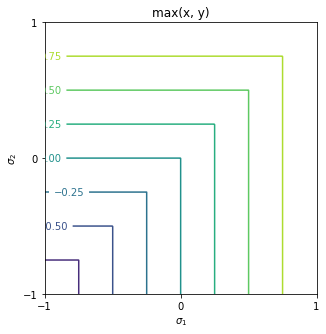

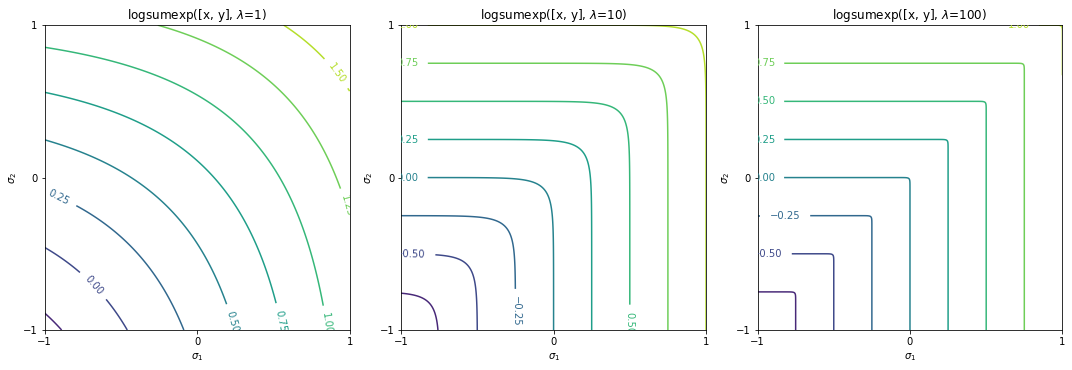

In [2]:
def logsumexp(x, lamb=1):
    # TODO: implement the logsumexp
    return np.log(np.sum(np.exp(x * lamb), axis=-1)) / lamb

# TODO: set up a grid of points in [-1, 1] x [-1, 1]
x = np.linspace(-1, 1, 500)
y = np.linspace(-1, 1, 500)
xy = np.stack(np.meshgrid(x, y, indexing='ij'), axis=-1)  # (500, 500, 2)

# TODO: I recommend you set up a function to set up an Axes object with the correct x, y labels, 
#       equal aspect and maybe x and y ticks.

def set_up_axes(ax):
    ax.set_xlabel(r'$\sigma_1$')
    ax.set_ylabel(r'$\sigma_2$')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_aspect('equal')

def plot_countour(arr, ax):
    cont = ax.contour(arr, extent=extent)
    ax.clabel(cont, cont.levels)
    
# TODO: calculate and plot the functions as specified in the task

extent = (x.min(), x.max(), y.min(), y.max())
fig, ax = plt.subplots(figsize=(5, 5))
set_up_axes(ax)
plot_countour(np.max(xy, axis=-1), ax)
plt.title('max(x, y)')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for lamb, ax in zip([1, 10, 100], axs.flatten()):
    set_up_axes(ax)
    plot_countour(logsumexp(xy, lamb), ax)
    ax.set_title(f'logsumexp([x, y], $\lambda$={lamb})')
    
    
plt.tight_layout()
plt.show()

We see that the softmax operation is a relaxation of the max operation, as expected from the name. The parameter $\lambda$ parametrizes the amount of relaxation.

(c)

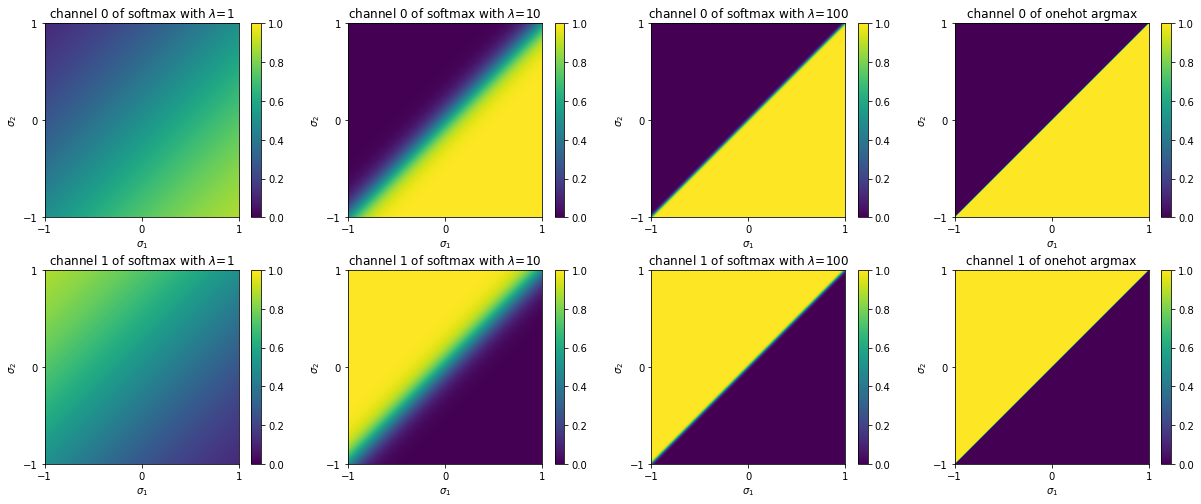

In [9]:
def to_onehot(x, l=None):
    if isinstance(x, int):
        x = np.array(x)
    l = x.max() + 1 if l is None else l  # use maximum label - 1 as default
    result = np.zeros(x.shape + (l,))
    np.put_along_axis(result, x[..., None], 1, -1)

## Alternative method for 2 classes
#     result = np.zeros(x.shape + (2,)).reshape(-1, 2)
#     result[x.flatten()==0, 0] = 1
#     result[x.flatten()==1, 1] = 1
#     result = result.reshape(*x.shape, 2)
    
    return result

def softmax(x, axis, lamb=1):
    # TODO: implement the softmax function. Axis should specify along which axis the sums should be computed.
    nominator = np.exp(x * lamb)
    denominator = np.sum(nominator, axis=axis, keepdims=True)
    return nominator / denominator
#     return F.softmax(torch.from_numpy(x*lamb), dim=axis).numpy()

        
# TODO: compute the argmax of each gridpoint in one-hot form
onehot_argmax = to_onehot(np.argmax(xy, axis=-1))

# TODO: make the plots as specified on the sheet (nicest is in a grid which you can get using plt.subplots)

# plot the softmax
fig, axs = plt.subplots(2, 4, figsize=(17, 7))
for ax_col, lamb in zip(axs[:, :-1].T, [1, 10, 100]):
    arr = softmax(xy, axis=-1, lamb=lamb)
    for i, ax in enumerate(ax_col):
        set_up_axes(ax)
#         ax.imshow(arr[..., i], origin='lower', extent=extent)
        im = ax.imshow(arr[..., i].T, vmin=0, vmax=1, origin='lower', extent=extent)
        plt.colorbar(im, ax=ax)
        ax.set_title(f'channel {i} of softmax with $\lambda$={lamb}')
        
# plot the onehot argmax
for i, ax in enumerate(axs[:, -1]):
    set_up_axes(ax)
    im = ax.imshow(onehot_argmax[..., i].T, vmin=0, vmax=1, origin='lower', extent=extent)
    plt.colorbar(im, ax=ax)
    ax.set_title(f'channel {i} of onehot argmax')
    
        
plt.tight_layout()

# 2) Top tagging with Point Clouds

See https://github.com/heidelberg-hepml/ml-tutorials for solutions

# 3) CNNs for Galaxy Classification

In [2]:
import h5py
import numpy as np
import torch

label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data07/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape=}, {labels.shape=}')

print(labels.shape, images.shape)
# TODO: print the number of samples for each class

images.shape=torch.Size([21785, 3, 69, 69]), labels.shape=torch.Size([21785])
torch.Size([21785]) torch.Size([21785, 3, 69, 69])


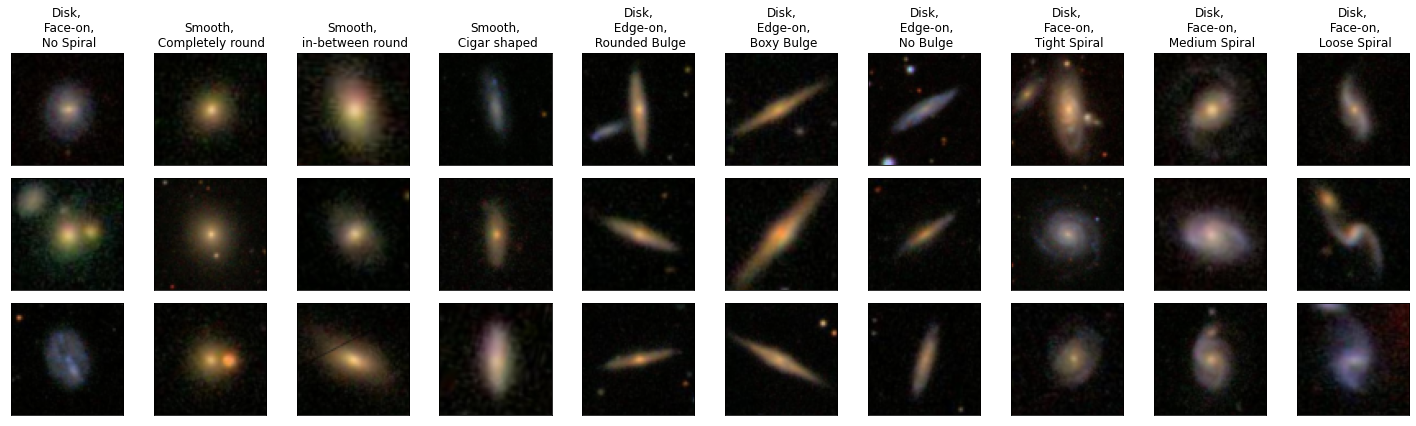

In [3]:
from matplotlib import pyplot as plt

# TODO: plot some samples of each class
itemindex = torch.where(labels == 3)
itemindex[:3]

samples_per_class = 3
fig, axss = plt.subplots(samples_per_class, n_classes, figsize=(n_classes * 2, samples_per_class * 2))
for label, (label_name, axs) in enumerate(zip(label_names, axss.T)):
    idx = torch.where(labels==label)[0][:samples_per_class] # take samples_per_class first occurences
    for i, (ind, ax) in enumerate(zip(idx, axs)):
        ax.imshow(images[ind].long().moveaxis(0, -1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title(label_name.replace(',',',\n'))
plt.tight_layout()
plt.show()

In [4]:
from torchvision.transforms import Normalize

# TODO: Compute the mean and standard deviation per channel over the dataset

# stds = images.moveaxis(1, 0).reshape(3, -1).std(axis=1)
# means = images.moveaxis(1, 0).reshape(3, -1).mean(axis=1)
stds, means = torch.tensor([37.5412, 31.3756, 26.3283]), torch.tensor([27.7014, 23.8241, 18.1425])
print(stds, means)

# TODO: Normalize the images
normalize = Normalize(means, stds)
images_normalized = normalize(images)

tensor([37.5412, 31.3756, 26.3283]) tensor([27.7014, 23.8241, 18.1425])


In [5]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

n_samples = len(labels)

# TODO: split the data in training and validation sets, stratifying by the labels
train_idx, val_idx = train_test_split(np.arange(n_samples), test_size=0.1, stratify=labels)

# TODO: create pytorch datasets for training and validation
train_dataset = TensorDataset(images_normalized[train_idx].float(), labels[train_idx].long())
val_dataset = TensorDataset(images_normalized[val_idx].float(), labels[val_idx].long())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

(a)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

#TODO: implement a small CNN as specified on the sheet
class GalaxyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(3136, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


(b)

  0%|          | 0/137 [00:00<?, ?it/s]

accuracy=0.02, avg_loss=2.31e+00


  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

accuracy=0.56, avg_loss=1.20e+00
val acc=0.5608077099586967 (best 0.5608077099586967)


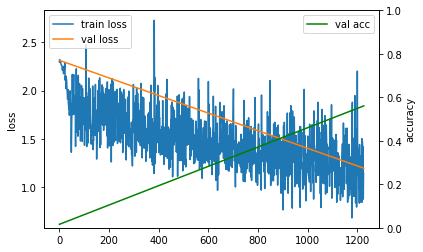

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

accuracy=0.62, avg_loss=1.03e+00
val acc=0.6190913262964662 (best 0.6190913262964662)


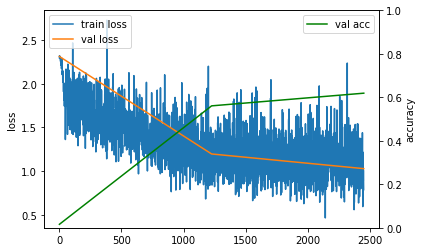

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

accuracy=0.63, avg_loss=9.79e-01
val acc=0.6342358880220285 (best 0.6342358880220285)


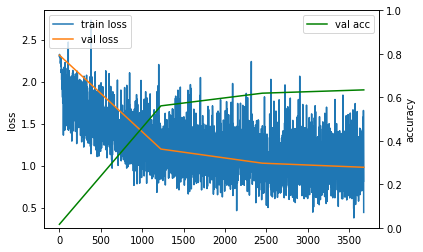

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

accuracy=0.64, avg_loss=9.50e-01
val acc=0.643414410279945 (best 0.643414410279945)


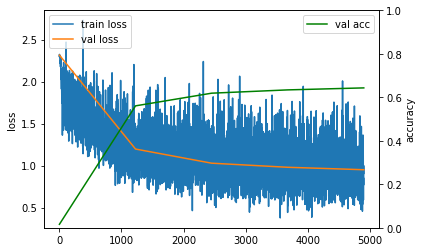

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

accuracy=0.68, avg_loss=9.12e-01
val acc=0.6750803120697567 (best 0.6750803120697567)


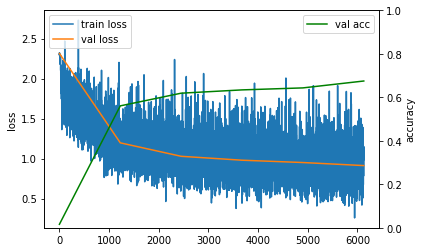

In [36]:
from torch.optim import Adam, SGD
from tqdm.auto import tqdm
import torchvision
from torchvision.models.resnet import ResNet, BasicBlock


# TODO: Instantiate the model, optimizer and criterion

model = GalaxyCNN()

# 2. Construct it from scratch with the correct number of output classes
# model = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=n_classes)

optimizer = Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
val_losses = []
val_accs = []

# TODO: Implement the training loop, validating after every epoch, and make the requested plots.

def validate(model):
    losses = []
    correct = []
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(val_loader)):
            y_pred = model(x)
            loss = criterion(y_pred, y)
            losses.append(loss.item())
            y_pred = torch.argmax(y_pred, dim=1)
            correct.extend((y_pred==y).numpy().tolist())
    avg_loss = np.mean(np.array(losses))
    accuracy = np.mean(np.array(correct))
    print(f'{accuracy=:.2f}, {avg_loss=:.2e}')
    return avg_loss, accuracy

val_loss, val_acc = validate(model)
val_losses.append(val_loss)
val_accs.append(val_acc)
for epoch in range(5):
#     print(f'Training epoch {epoch}')
    for i, (x, y) in enumerate(tqdm(train_loader)):
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss.item())
            
    # validate
    val_loss, val_acc = validate(model)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_accs[-1] == np.max(val_accs):
        torch.save(model, 'model.pytorch')
    print(f'val acc={val_accs[-1]} (best {np.max(val_acc)})')
    if True: #epoch % 10 == 0:
        plt.plot(train_losses, label='train loss')
        plt.plot((np.arange(epoch+2))*len(train_loader), val_losses, label='val loss')
        plt.legend(loc='upper left')
        plt.ylabel('loss')
        ax2 = plt.gca().twinx()
        ax2.plot((np.arange(epoch+2))*len(train_loader), val_accs, label='val acc', c='green')
        ax2.set_ylim(0, 1)
        plt.xlabel('training iteration')
        plt.ylabel('accuracy')
        plt.legend(loc='upper right')
        plt.show()
            

In [37]:
y_pred, y_true = np.zeros(0), np.zeros(0)
for x, y_true_i in val_loader:
    y_pred_i = model(x)
    y_pred_i = torch.argmax(y_pred_i, axis=1) # pick class with highest probability
    y_true = np.concatenate((y_true, y_true_i.detach().cpu().numpy()), axis=0)
    y_pred = np.concatenate((y_pred, y_pred_i.detach().cpu().numpy()), axis=0)
print(y_pred.shape, y_true.shape)

(2179,) (2179,)


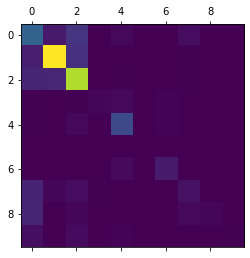

In [38]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true, y_pred)
plt.matshow(matrix)
plt.show()

(c)

  0%|          | 0/137 [00:00<?, ?it/s]

accuracy=0.02, avg_loss=2.74e+00


  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

accuracy=0.66, avg_loss=9.11e-01
val acc=0.6636071592473611 (best 0.6636071592473611)


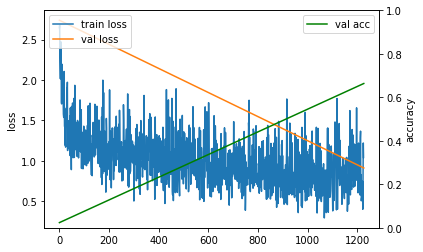

In [8]:
from torch.optim import Adam, SGD
from tqdm.auto import tqdm
import torchvision
from torchvision.models.resnet import ResNet, BasicBlock


# TODO: Instantiate the model, optimizer and criterion

# Two ways to set up the resnet
# 1. Get the standard one with 1000 classes, overwrite the final linear layer
model = torchvision.models.resnet34()
model.fc = nn.Linear(in_features=512, out_features=n_classes, bias=True)

# 2. Construct it from scratch with the correct number of output classes
# model = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=n_classes)

optimizer = Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
val_losses = []
val_accs = []

# TODO: Implement the training loop, validating after every epoch, and make the requested plots.

def validate(model):
    losses = []
    correct = []
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(val_loader)):
            y_pred = model(x)
            loss = criterion(y_pred, y)
            losses.append(loss.item())
            y_pred = torch.argmax(y_pred, dim=1)
            correct.extend((y_pred==y).numpy().tolist())
    avg_loss = np.mean(np.array(losses))
    accuracy = np.mean(np.array(correct))
    print(f'{accuracy=:.2f}, {avg_loss=:.2e}')
    return avg_loss, accuracy

val_loss, val_acc = validate(model)
val_losses.append(val_loss)
val_accs.append(val_acc)
for epoch in range(1):
#     print(f'Training epoch {epoch}')
    for i, (x, y) in enumerate(tqdm(train_loader)):
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss.item())
            
    # validate
    val_loss, val_acc = validate(model)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_accs[-1] == np.max(val_accs):
        torch.save(model, 'model.pytorch')
    print(f'val acc={val_accs[-1]} (best {np.max(val_acc)})')
    if True: #epoch % 10 == 0:
        plt.plot(train_losses, label='train loss')
        plt.plot((np.arange(epoch+2))*len(train_loader), val_losses, label='val loss')
        plt.legend(loc='upper left')
        plt.ylabel('loss')
        ax2 = plt.gca().twinx()
        ax2.plot((np.arange(epoch+2))*len(train_loader), val_accs, label='val acc', c='green')
        ax2.set_ylim(0, 1)
        plt.xlabel('training iteration')
        plt.ylabel('accuracy')
        plt.legend(loc='upper right')
        plt.show()
            